In [2]:
# imports
from __future__ import absolute_import, division, print_function
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns
# if the line below doesn't work in jupyter
# launch it with admin priviledges
# or just use a preprepared venv
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except:
    !pip install tensorflow
    import tensorflow as ts
    from tensorflow import keras
    from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [3]:
# read the data
dataset = pd.read_csv("sortedDataTop1.csv")
dataset_copy = dataset.copy()
# split it into 2 pieces - train and test, test being 80% of all
train_dataset = dataset_copy.sample(frac=0.8, random_state=0)
test_dataset = dataset_copy.drop(train_dataset.index)
print(len(train_dataset.index))
# print(len(test_dataset.index))

191786


In [4]:
# not sure the reason for the code below, it doesn't work as intended
# split features from labels
# warning: run below code only once
# it throws KeyError if argument is already popped

if True:
    train_labels_prop = train_dataset.pop("Proportional")
    train_labels_int = train_dataset.pop("Integral")
    train_labels_der = train_dataset.pop("Derivative")
    data_train = {
        'Proportional': train_labels_prop,
        'Integral': train_labels_int,
        'Derivative': train_labels_der
    }
    train_labels = pd.DataFrame(data_train)
    # same for test
    test_labels_prop = test_dataset.pop("Proportional")
    test_labels_int = test_dataset.pop("Integral")
    test_labels_der = test_dataset.pop("Derivative")
    data_test = {
        'Proportional': test_labels_prop,
        'Integral': test_labels_int,
        'Derivative': test_labels_der
    }
    test_labels = pd.DataFrame(data_test)

train_labels
# test_labels

,Proportional,Integral,Derivative
137613,4.0,0.3,2.4
119939,16.0,1.3,0.4
77665,14.0,1.5,0.4
72519,6.0,0.5,1.2
221327,9.0,0.1,1.2
...,...,...,...
197778,10.0,0.5,0.8
15299,7.0,0.7,0.4
166731,13.0,0.7,0.4
55301,15.0,1.5,0.4


In [5]:
# some statistics about the values
# sns.pairplot(dataset)
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
print("Train stats:")
train_stats

Train stats:


,count,mean,std,min,25%,50%,75%,max
Area,191786.0,15.926381,3.693254,1.0,14.0,17.0,19.0,20.0
Beta,191786.0,6.080413,2.660454,0.0,4.0,6.5,8.5,9.5
Tp,191786.0,0.549178,0.274814,0.1,0.3,0.5,0.8,1.0


In [10]:
# normalize the data
# here we have 3 columns in x but 6 columns in train stats so we get 3 NaNs
# changed command order to fix it, but previously it was [statistics block] -> [pop labels block]
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_dataset = norm(train_dataset)
normed_test_dataset = norm(test_dataset)
# normed_train_dataset = train_dataset.copy()
# normed_test_dataset = test_dataset.copy()
normed_train_dataset

,Area,Beta,Tp
137613,0.290697,1.285340,1.276579
119939,0.290697,-0.406101,-0.542831
77665,-0.250831,-0.218163,-0.178949
72519,-0.250831,-1.533728,1.640461
221327,1.102989,0.345651,-0.542831
...,...,...,...
197778,0.832225,1.097402,1.276579
15299,-1.875414,1.097402,-0.178949
166731,0.561461,1.285340,0.548815
55301,-0.521595,-1.721666,0.912697


In [7]:
# save the stats from above for denormalization in later use
stats_dir = 'D:\\Dev\\PyCharmProjects\\ISSlab1\\programs\\'
file_stats = open(str(stats_dir) + "MLPID_stats.txt", "w")
# save the mean
# file_stats.write("train_stats['mean'])\n")
sentence = "".join(str(train_stats['mean']) + "\n")
file_stats.write(sentence)
# save the sigma
# file_stats.write("train_stats['std'])\n")
sentence = "".join(str(train_stats['std']) + "\n")
file_stats.write(sentence)
# finish
file_stats.close()
train_stats

,count,mean,std,min,25%,50%,75%,max
Area,191786.0,15.926381,3.693254,1.0,14.0,17.0,19.0,20.0
Beta,191786.0,6.080413,2.660454,0.0,4.0,6.5,8.5,9.5
Tp,191786.0,0.549178,0.274814,0.1,0.3,0.5,0.8,1.0


In [33]:
# the fun part: building a model!
# we need 3 inputs and 3 outputs

def build_model():
    model = keras.Sequential([
        # 3 input layers, relu function, that is passed to another input like it and then to output layer
        layers.Dense(3, input_dim=3),
        # this layer below might be useless, to be checked
        layers.Dense(12),
        layers.Dense(3)
    ])
    # optimizer: RMS
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # alternative opt: adam
    optimizer = 'adam'

    # compile the model:
    # -loss is mean squared error
    # -metrics are mean quared error and mean absolute error
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model
model = build_model()

In [34]:
# get some info about the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 39        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [35]:
# check if everythings connected and no errors are given 
example_batch = normed_train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[ 8.96571040e-01, -7.01947510e-02, -8.19534481e-01],
       [-4.44792032e-01,  6.68465793e-02,  4.59962755e-01],
       [-8.01316053e-02,  6.78439625e-04,  4.20601591e-02],
       [ 5.56152835e-02, -1.00489044e+00,  2.36883581e-01],
       [-3.78391027e-01,  2.76978791e-01,  4.44961339e-01],
       [ 2.23919749e-02,  6.78177714e-01, -1.61444634e-01],
       [ 4.56559539e-01, -5.83095513e-02, -3.09486866e-01],
       [-5.58196604e-02, -1.52657062e-01,  2.66991317e-01],
       [ 3.29601318e-01,  2.46028125e-01, -6.41489446e-01],
       [-1.46371305e-01,  3.35928202e-01,  1.17097124e-01]], dtype=float32)

In [36]:
# train the model
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.',end='')
# number of 
EPOCHS = 1000

# early stop in case we start overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    normed_train_dataset, train_labels,
    epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks=[early_stop, PrintDot()]
)
print('\n' + 'Fitting done')


......................
Fitting done


In [37]:
# model fit summary
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail

<bound method NDFrame.tail of         loss       mae       mse  val_loss   val_mae   val_mse  epoch
0   8.313260  1.533536  8.313260  4.913250  1.305595  4.913250      0
1   4.929467  1.306795  4.929467  4.913383  1.302307  4.913383      1
2   4.928780  1.306544  4.928780  4.937388  1.310885  4.937388      2
3   4.930265  1.306853  4.930265  4.924114  1.303249  4.924114      3
4   4.928388  1.306430  4.928388  4.916996  1.305311  4.916996      4
5   4.928983  1.306694  4.928983  4.910961  1.305241  4.910961      5
6   4.930129  1.306796  4.930129  4.921344  1.305002  4.921344      6
7   4.927697  1.306593  4.927697  4.919111  1.300327  4.919111      7
8   4.928867  1.306627  4.928867  4.915853  1.300828  4.915853      8
9   4.928916  1.306631  4.928916  4.933465  1.316278  4.933465      9
10  4.927842  1.306451  4.927842  4.915166  1.305562  4.915166     10
11  4.928864  1.306741  4.928864  4.908248  1.304640  4.908248     11
12  4.928020  1.306508  4.928020  4.947740  1.317713  4.9477

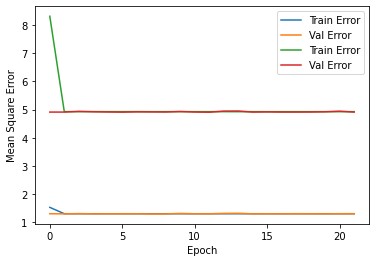

In [38]:
# learning curves
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()

    # plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    # plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history) 

In [39]:
# test the model
loss, mae, mse = model.evaluate(normed_test_dataset, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Testing set Mean Sqr Error: {:5.2f}".format(mse))

Testing set Mean Abs Error:  1.31
Testing set Mean Sqr Error:  4.92


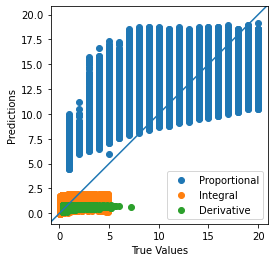

In [40]:
# make some predictions

test_predictions = model.predict(normed_test_dataset)
# print('type of test_label: ' + str(type(test_labels)))
# print('type of test_pred: ' + str(type(test_predictions)))
# test_label is a dataframe so we need predicions to also be a dataframe
test_pred = pd.DataFrame(test_predictions, columns=['Proportional', 'Integral', 'Derivative'])

test_labels_p = test_labels['Proportional']
test_pred_p = test_pred['Proportional']
test_labels_i = test_labels['Integral']
test_pred_i = test_pred['Integral']
test_labels_d = test_labels['Derivative']
test_pred_d = test_pred['Derivative']
plt.scatter(test_labels_p, test_pred_p)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.scatter(test_labels_i, test_pred_i)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.scatter(test_labels_d, test_pred_d)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.legend(['Proportional','Integral', 'Derivative'])
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# straight line if you would like to 
_ = plt.plot([-100, 100], [-100, 100])

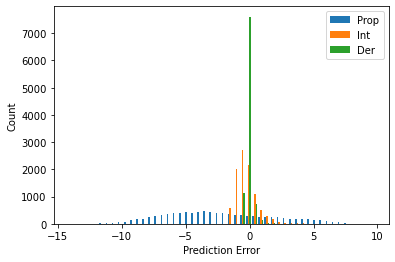

In [41]:
error = test_labels - test_pred
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.legend(['Prop','Int','Der'])
_ = plt.ylabel("Count")

In [42]:
# try one prediction
inpar = pd.DataFrame(norm([5, 1, 0.1]))
prd = model.predict(inpar.transpose())
sprd = pd.Series(prd.flatten(),index=['Prop','Int','Der'])
sprd

Prop    12.065116
Int      0.149383
Der      0.355671
dtype: float32

In [44]:
# save the model
import tempfile
import os

# export path
# model_dir = tempfile.gettempdir()
model_dir = 'D:\\Dev\\PyCharmProjects\\ISSlab1\\programs\\saved models'
# model_dir returns 'C:\\Users\\Hubert\\AppData\\Local\\Temp'
version = "version-ml-pid"
export_path = os.path.join(model_dir, version)

# saving
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: D:\Dev\PyCharmProjects\ISSlab1\programs\saved models\version-ml-pid\assets
